In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = [8, 5.3]

## Ejemplo: El problema de los sobornos con redes neuronales

In [3]:
# This code generates the bribes dataset. No need to understand it, it is just to avoid to have to 
# upload the csv to colab.
def simulate_bribes():
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))


    np.random.seed(69)
    n = 1024
    sobornos = np.random.uniform(size=(n,)) * 200 + 100
    notas = 10 * sigmoid(2 * (sobornos - 200) / 46)
    sobornos = sobornos + 8 * np.random.normal(size=(n,))
    sobornos /= 100

    # With neural networks, data always should have matrix shape
    X = notas.reshape(-1, 1)
    y = sobornos.reshape(-1, 1)

    return X, y



MSE al final del entrenamiento es 0.009466536343097687
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


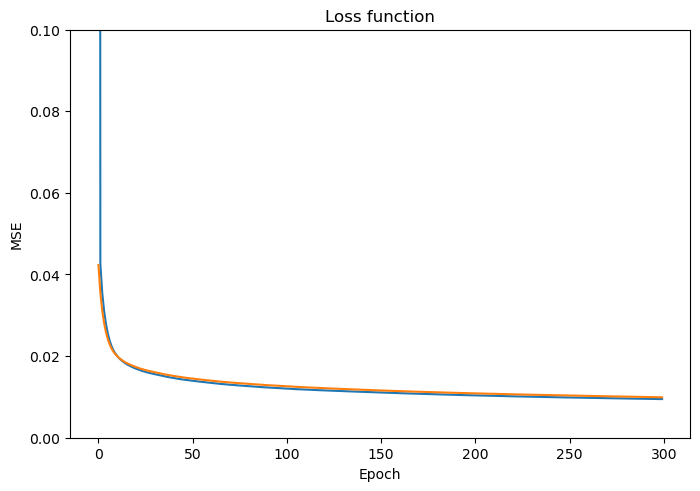

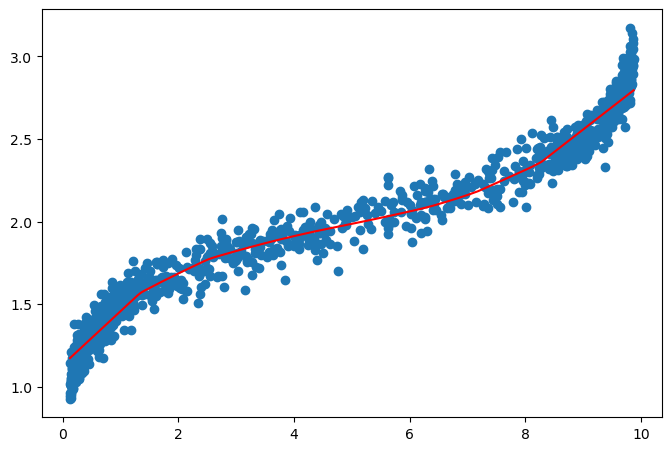

In [4]:
keras.utils.set_random_seed(813)

X, y = simulate_bribes()
# It is a good idea to alway normalize the input data
X_normalized = (X - X.mean(axis=0)) / X.std(axis=0)

model = keras.Sequential([
    keras.layers.InputLayer(shape=(1,)),
    keras.layers.Dense(512, activation='leaky_relu'),
    keras.layers.Dense(1, activation=None),
])
# print(model.summary())
optimizer = keras.optimizers.SGD(learning_rate = 1e-1)

model.compile(optimizer=optimizer, loss='mse')

# Note the batch size: it is the number of samples used to compute the gradient
history = model.fit(X_normalized, y, batch_size=128, epochs=300, verbose=0, 
                    validation_split=0.2)

# We can plot the loss function to see how it evolves
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.ylim(0, 0.1)
plt.title("Loss function")
plt.xlabel("Epoch")
plt.ylabel("MSE")
print(f"MSE al final del entrenamiento es {history.history['loss'][-1]}")

# Now plot the predictions. Recall that we should be using a train-test split. This is just for 
# simplicity
plt.figure()
plt.scatter(X.flatten(), y.flatten())
# sort by X to avoid plotting artifacts
sort_idx = np.argsort(X.flatten())
preds = model.predict(X_normalized[sort_idx])
plt.plot(X.flatten()[sort_idx], preds.flatten(), c='red')

### Ejercicio: Modificando la arquitectura, optimizador y otros hiperparámetros
Modifica el anterior fragmento de código para ....
1. Tener dos capas ocultas con 512 hidden units. Usa la activación "relu" en ambas capas.
2. Usar un optimizador distinto: Adam con lr = 1e-3
2. Entrenar usando 200 epochs y un batch_size de 64.

In [5]:
X, y = simulate_bribes()
# ...

## Ejemplo: PetFinder.my, Clasificación binaria y regularización L2 + Early Stopping
Usaremos el dataset "PetFinder.my mini", en el que se recogen datos de la web de Malasia "PetFinder.my", orientada a la adopción de animales callejeros. El objetivo es predecir si un animal ha sido adoptado o no.

In [8]:
# Downloading the data, no need to understand this code
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder_mini_extracted/petfinder-mini/petfinder-mini.csv'

keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)
# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

print(dataframe.head())

  Type  Age                Breed1  Gender Color1    Color2 MaturitySize  \
0  Cat    3                 Tabby    Male  Black     White        Small   
1  Cat    1  Domestic Medium Hair    Male  Black     Brown       Medium   
2  Dog    1           Mixed Breed    Male  Brown     White       Medium   
3  Dog    4           Mixed Breed  Female  Black     Brown       Medium   
4  Dog    1           Mixed Breed    Male  Black  No Color       Medium   

  FurLength Vaccinated Sterilized   Health  Fee  PhotoAmt  target  
0     Short         No         No  Healthy  100         1       1  
1    Medium   Not Sure   Not Sure  Healthy    0         2       1  
2    Medium        Yes         No  Healthy    0         7       1  
3     Short        Yes         No  Healthy  150         8       1  
4     Short         No         No  Healthy    0         3       1  


In [18]:
# Let's use sklearn to one-hot encode categorial features, normalize numeric ones, and split the data into train, val and test:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from keras import regularizers

X = dataframe.drop(columns=['target'])
y = dataframe['target'].values

cat_columns = ['Type', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health']
num_columns = ['Age', 'Fee', 'PhotoAmt']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False), cat_columns),
        ('standardize', StandardScaler(), num_columns)
    ]
)

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=234)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


(8075, 185)
Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7067 - loss: 0.2238 - val_accuracy: 0.7475 - val_loss: 0.1772
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7574 - loss: 0.1753 - val_accuracy: 0.7481 - val_loss: 0.1757
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7669 - loss: 0.1674 - val_accuracy: 0.7447 - val_loss: 0.1758
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7780 - loss: 0.1610 - val_accuracy: 0.7377 - val_loss: 0.1772
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7907 - loss: 0.1542 - val_accuracy: 0.7458 - val_loss: 0.1795


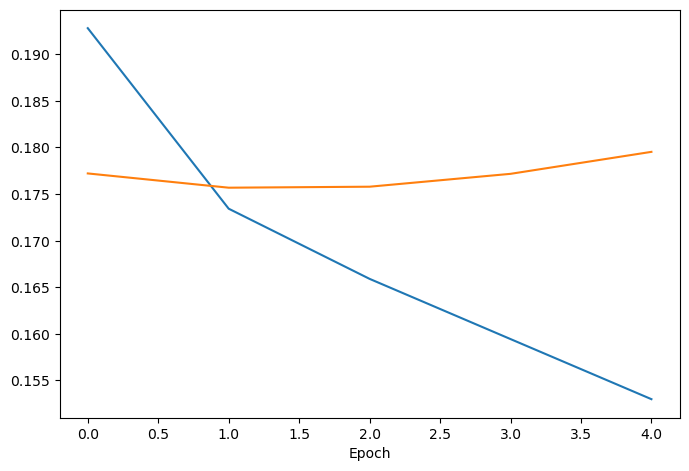

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7834 - loss: 0.1711
[0.17676253616809845, 0.7631427049636841]


In [19]:
print(X_train.shape)
# Now we can train a neural network
model = keras.Sequential([
        keras.Input(shape=(X_train.shape[1], )),
        # !!!!!!!!!!!!!!!!!!! Let's try L2 regularization !!!!!!!!!!!!!!!!!!!
        keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(l2=1e-5)),
        keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(l2=1e-5)),
        keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(l2=1e-5)),
        # !!!!!!!!!!!!!!!!!!!!!! Change the activation !!!!!!!!!!!!!!!!!!!!!! 
        # !!!!!!!!!!!!!!!!!!!!!! It is sooooo wrong !!!!!!!!!!!!!!!!!!!!!!
        keras.layers.Dense(1, activation=None),
])
# !!!!!! Change the loss function !!!!!!
# !!!!!! It is sooooo wrong !!!!!!
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              loss="mse",
              metrics=["accuracy"]
)

# !!!!!!!!!!!!!!!!!!! Add early stopping !!!!!!!!!!!!!!!!!!! 
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10, 
    validation_data=(X_val, y_val),
    callbacks=[callback]

)

# plot train and val loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.show()


# !!!!!!!!!!!!!!!!!!! Note the use of evaluation !!!!!!!!!!!!!!!!!!!
results = model.evaluate(X_test, y_test)
print(results)


### Ejemplo: MNIST, Clasificación multiclase y regularización con Dropout y BatchNorm
En este ejemplo intentaremos resolver MNIST usando una red neuronal multicapa. Como veremos más adelante, esta aproximación no es óptima.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  

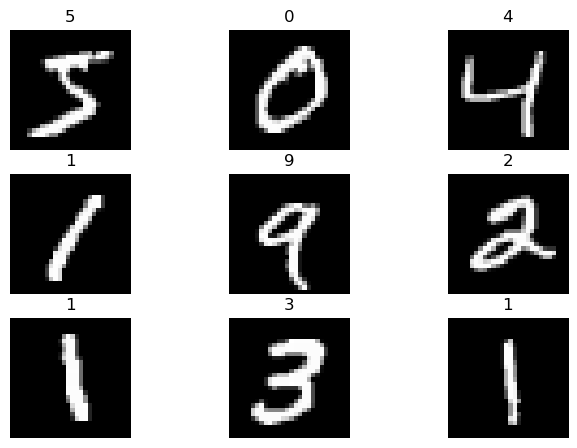

In [11]:
# get MNIST dataset, split in train test  and plot some examples
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')



# images are 28 x 28 pixels represented as a matrix. Values of this matrix go from 0 to 255
print(X_train[0].shape)
print(X_train[0])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0981 - loss: 21.8295 - val_accuracy: 0.1135 - val_loss: 9.0222
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1103 - loss: 9.7348 - val_accuracy: 0.1135 - val_loss: 8.3868
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1100 - loss: 9.3913 - val_accuracy: 0.1135 - val_loss: 8.7309
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1104 - loss: 9.0909 - val_accuracy: 0.1135 - val_loss: 8.4430
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1100 - loss: 8.9515 - val_accuracy: 0.1135 - val_loss: 8.4120
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1100 - loss: 8.8322 - val_accuracy: 0.1135 - val_loss: 8.4083
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1100 - loss: 8.6955 - val_accuracy: 0.1135 - val_loss: 8.3858
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1100 - loss: 8.7132 - val_accuracy: 0

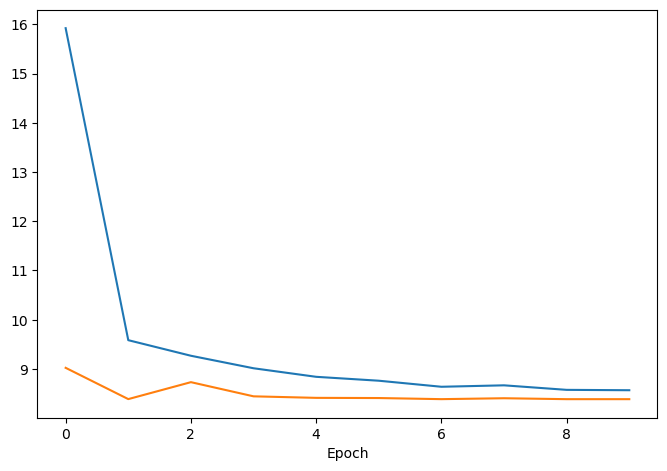

In [15]:
# Normalize data
X_train = X_train / 255
X_test = X_test / 255

# Let's subset the data for faster training. Don't do this on real data!
X_train = X_train[:10000]
y_train = y_train[:10000]

# build the model with a flatten layer. 
# !!!!!!!!!!!!!!!!!!! Use Dropout and BatchNormalization !!!!!!!!!!!!!!!!!!!
# This is just for illustration purposes. While both can be used together, some research 
# suggests they might be partially redundant since both techniques help with regularization.
# You might need to tune the dropout rate when using it with BatchNorm.
model = keras.Sequential([
    keras.layers.Input(shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    # !!!!!!!!!!!!!!!!!!! Change the activation !!!!!!!!!!!!!!!!!!!
    # !!!!!!!!!!!!!!!!!!! It is sooooo wrong !!!!!!!!!!!!!!!!!!!
    keras.layers.Dense(1, activation=None)
])

# !!!!!!!!!!!!!!!!!!! Change the loss function !!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!! It is sooooo wrong !!!!!!!!!!!!!!!!!!!
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')


print(model.evaluate(X_test, y_test))

